In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# Data preprocessing functions
def preprocess_data(df):
    columns_to_drop = [
        'Dst Port', 'Timestamp', 'Fwd PSH Flags', 'Bwd PSH Flags',
        'Fwd URG Flags', 'Bwd URG Flags', 'Flow Byts/s', 'Flow Pkts/s'
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df["Label"] != "Label"]

    attack_mapping = {
        'Benign': 0, 'DDOS attack-HOIC': 1, 'DoS attacks-Hulk': 2,
        'Bot': 3, 'FTP-BruteForce': 4, 'SSH-Bruteforce': 5,
        'Infilteration': 6, 'DoS attacks-GoldenEye': 7,
        'DoS attacks-Slowloris': 8, 'DDOS attack-LOIC-UDP': 9,
        'Brute Force -Web': 10, 'Brute Force -XSS': 11, 'SQL Injection': 12
    }

    df.loc[:, 'Label'] = df["Label"].map(attack_mapping)
    return df

In [19]:
def scale_features(df):
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    feature_cols = df.drop('Label', axis=1).columns
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df_scaled.groupby("Label").apply(lambda a: a)


In [20]:
# Metrics calculation
def calculate_metrics(output, y_test, y_test_types, att_type):
    tp = tn = fp = fn = tpz = fnz = 0
    output = output.flatten()

    for i in range(len(output)):
        if output[i] < 0.5:
            if y_test[i] == 0:
                tn += 1
            else:
                fn += 1
        else:
            if y_test[i] == 1:
                tp += 1
            else:
                fp += 1
        if y_test_types[i] == att_type:
            if output[i] >= 0.5:
                tpz += 1
            else:
                fnz += 1

    accuracy = ((tp + tn) * 100) / (tp + tn + fp + fn)
    dr = (tp * 100) / (tp + fn) if (tp + fn) > 0 else 0
    far = (fp * 100) / (fp + tn) if (fp + tn) > 0 else 0
    zdr = (tpz * 100) / (tpz + fnz) if (tpz + fnz) > 0 else 0

    return [accuracy, dr, far, zdr]

In [21]:
# RNN Model creation
def create_rnn_model(input_shape, lstm_units=100):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((-1, 1)),  # Reshape for RNN input
        layers.LSTM(lstm_units, return_sequences=True),
        layers.LSTM(lstm_units),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [22]:
# Main execution function
def run_zero_shot_detection(df):
    # Preprocess data
    df_processed = preprocess_data(df)
    df_scaled = scale_features(df_processed)

    metricarr = []
    input_shape = (71,)  # Number of features

    # Train and evaluate for each attack type
    for att_type in range(1, 13):
        print(f"\nProcessing attack type {att_type}")

        # Split data for zero-day simulation
        df_train, df_test = train_test_split(df_scaled, train_size=0.8, random_state=52)
        zday = df_train[df_train["Label"] == att_type]
        df_test = pd.concat([df_test, zday]).sample(frac=1).reset_index(drop=True)
        zday_train = df_train[df_train["Label"] != att_type].sample(frac=1).reset_index(drop=True)

        # Prepare training data
        X_train = zday_train.drop(["Label"], axis=1)
        y_train = zday_train["Label"].apply(lambda a: 1 if a > 0 else 0)

        # Prepare test data
        X_test = df_test.drop(["Label"], axis=1)
        y_test_types = df_test["Label"]
        y_test = y_test_types.apply(lambda a: 1 if a > 0 else 0)

        # Create and train model
        tf.keras.backend.clear_session()
        model = create_rnn_model(input_shape)
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=3,
            verbose=1,
            restore_best_weights=True
        )

        model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=64,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate model
        output = model.predict(X_test)
        metrics = calculate_metrics(output, y_test, y_test_types, att_type)
        metricarr.append(metrics)

        print(f"Attack Type {att_type} Metrics:")
        print(f"Accuracy: {metrics[0]:.2f}%")
        print(f"Detection Rate: {metrics[1]:.2f}%")
        print(f"False Alarm Rate: {metrics[2]:.2f}%")
        print(f"Zero-day Detection Rate: {metrics[3]:.2f}%")

    return np.array(metricarr)

In [23]:
# Visualization functions
def plot_metrics(metricarr):
    mdf = pd.DataFrame(metricarr, columns=['Accuracy', 'DR', 'FAR', 'ZDR'])

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    sns.barplot(data=mdf, x=mdf.index+1, y='DR', label='Detection Rate')
    plt.xlabel('Attack Types')
    plt.ylabel('Detection Rate (%)')
    plt.title('Detection Rates by Attack Type')

    plt.subplot(2, 1, 2)
    sns.barplot(data=mdf, x=mdf.index+1, y='ZDR', label='Zero-day Detection Rate')
    plt.xlabel('Attack Types')
    plt.ylabel('Zero-day Detection Rate (%)')
    plt.title('Zero-day Detection Rates by Attack Type')

    plt.tight_layout()
    plt.show()

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
pd.options.display.max_rows = 200

In [26]:
df=pd.read_csv("/content/drive/MyDrive/CIC-IDS-2018.csv")
df

<ipython-input-26-74ac0b165da8>:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/drive/MyDrive/CIC-IDS-2018.csv")


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,57610,6,02/03/2018 04:14:05,25,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,52347,6,02/03/2018 02:48:44,63,3,1,31,0.0,31,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,55970,6,16/02/2018 01:46:19,4217799,5,3,935,350.0,935,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,80,6,02/03/2018 05:17:21,54499550,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,3389,6,02/03/2018 01:53:13,2697973,9,10,1278,1677.0,677,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828419,22,6,14/02/2018 03:13:27,381223,22,22,1912,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,SSH-Bruteforce
828420,22,6,14/02/2018 03:27:51,324836,23,20,1928,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,SSH-Bruteforce
828421,22,6,14/02/2018 02:39:25,393769,22,20,1944,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,SSH-Bruteforce
828422,22,6,14/02/2018 03:16:09,297287,22,22,1928,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,SSH-Bruteforce


In [27]:
metrics = run_zero_shot_detection(df)

<ipython-input-19-17328fb6e4a7>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_scaled.groupby("Label").apply(lambda a: a)



Processing attack type 1
Epoch 1/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - accuracy: 0.8760 - loss: 0.3820
Epoch 2/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.8762 - loss: 0.3765
Epoch 3/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.8757 - loss: 0.3763
Epoch 4/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.8761 - loss: 0.3750
Epoch 5/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.8770 - loss: 0.3732
Epoch 6/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.8766 - loss: 0.3738
Epoch 7/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - accuracy: 0.8771 - loss: 0.3727
Epoch 8/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.8768 - loss: 0.3733
Epoch 9/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.8766 - loss: 0.3737
Epoch 10/10
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.8769 - loss: 0.3732
Restoring model weights from the end of the best epoch: 10.
4825/482

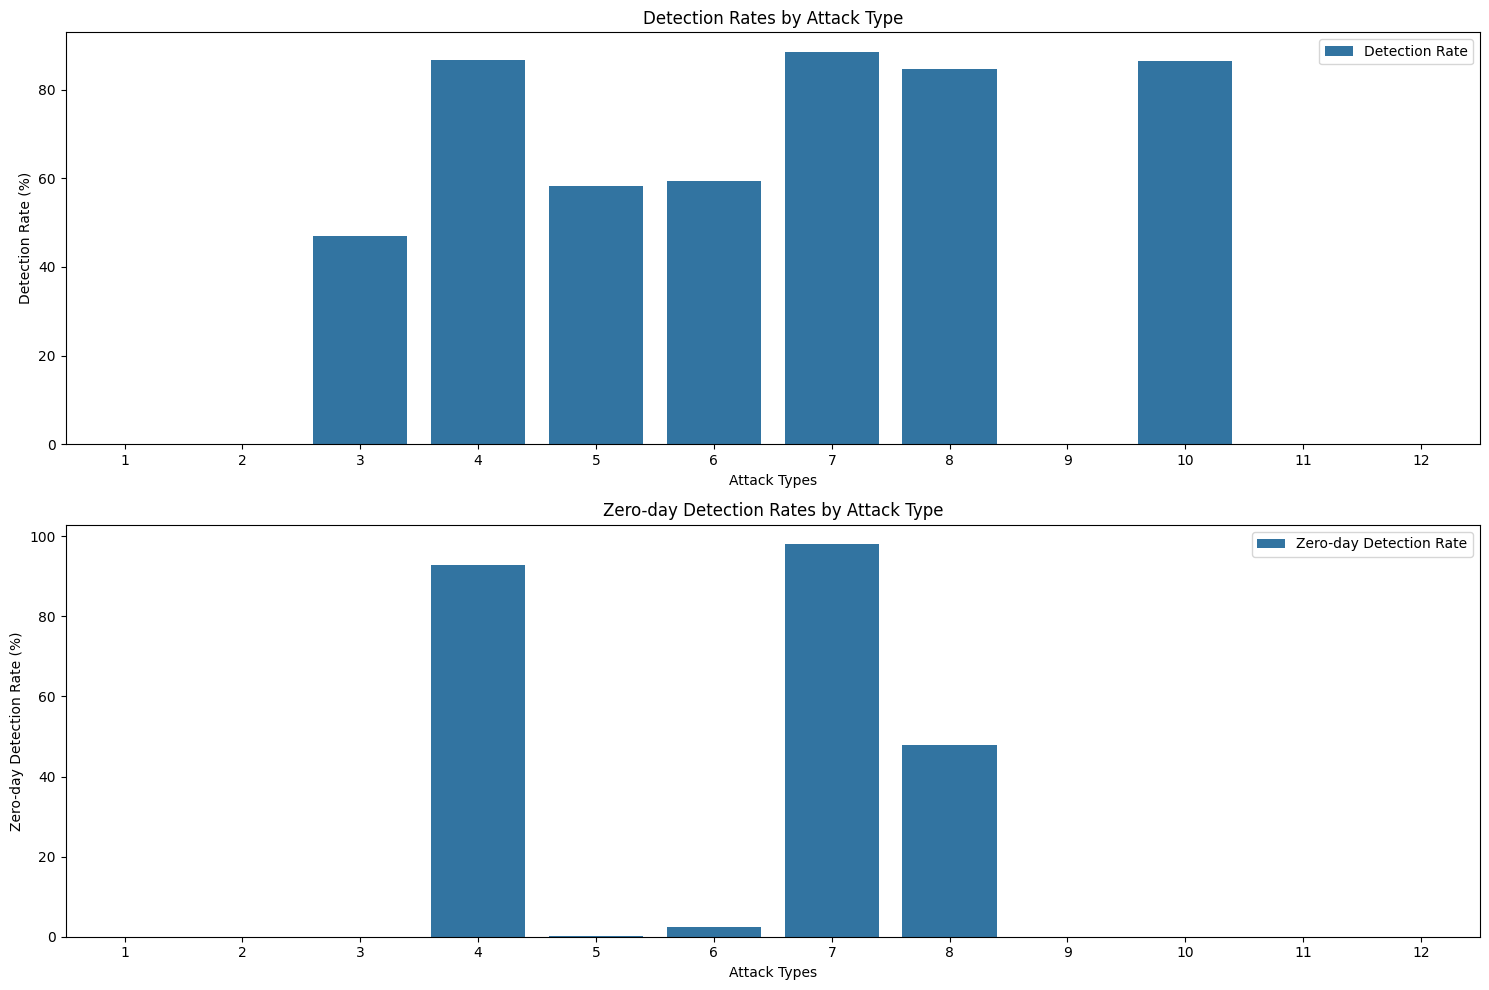

In [28]:
plot_metrics(metrics)

In [29]:
from scipy.stats import wasserstein_distance as wd
from scipy.stats import ks_2samp as ks